In [ ]:
%%capture
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import os


football_files_path = "/content/drive/MyDrive/bookmaker-model/football/"
basketball_files_path = "/content/drive/MyDrive/bookmaker-model/basketball/"

football_csv_files = os.listdir(football_files_path)
football_csv_files = [football_files_path + e for e in football_csv_files if not e.startswith('.') ]

basketball_csv_files = os.listdir(basketball_files_path)
basketball_csv_files = [basketball_files_path + e for e in basketball_csv_files if not e.startswith('.') ]

def create_df(file_paths):
    full_data = pd.DataFrame()
    for file in file_paths:
        with open(file) as file_in:
            print(f"reading {file}")
            part_df = pd.read_csv(file)
            full_data = pd.concat([full_data, part_df], axis=0)

    return full_data

football_df = create_df(football_csv_files)
basketball_df = create_df(basketball_csv_files)

reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2008-2009.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2007-2008.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2009-2010.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2012-2013.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2010-2011.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2011-2012.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2013-2014.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2014-2015.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2015-2016.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2017-2018.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2016-2017.csv
reading /content/drive/MyDrive/bookmaker-model/football/football-odds-2019-2

In [ ]:
football_df.columns = ['match', 'bookmaker', 'home-odds', 'draw-odds', 'away-odds', 'date', 'score']
football_df.shape

(276960, 7)

In [ ]:
basketball_df.columns = ['match', 'bookmaker', 'home-odds', 'away-odds', 'date', 'score']
basketball_df.shape

(589612, 6)

In [ ]:
basketball_df.head()

,match,bookmaker,home-odds,away-odds,date,score
0,Denver Nuggets\n97\n–\nLos Angeles Lakers\n103,bet-at-home,-167,129,"Sunday, 24 May 2009, 00:30",97:103
1,Denver Nuggets\n97\n–\nLos Angeles Lakers\n103,bet365,-175,145,"Sunday, 24 May 2009, 00:30",97:103
2,Denver Nuggets\n97\n–\nLos Angeles Lakers\n103,bwin,-154,129,"Sunday, 24 May 2009, 00:30",97:103
3,Denver Nuggets\n97\n–\nLos Angeles Lakers\n103,Interwetten,-182,125,"Sunday, 24 May 2009, 00:30",97:103
4,Denver Nuggets\n97\n–\nLos Angeles Lakers\n103,Pinnacle,-159,152,"Sunday, 24 May 2009, 00:30",97:103


In [ ]:
football_df.head()

,match,bookmaker,home-odds,draw-odds,away-odds,date,score
0,Wigan\n1\n–\nManchester Utd\n2,bet-at-home,1000,420,-400,"Wednesday, 13 May 2009, 19:00",1:2
1,Wigan\n1\n–\nManchester Utd\n2,bet365,1200,400,-345,"Wednesday, 13 May 2009, 19:00",1:2
2,Wigan\n1\n–\nManchester Utd\n2,bwin,900,400,-400,"Wednesday, 13 May 2009, 19:00",1:2
3,Wigan\n1\n–\nManchester Utd\n2,Pinnacle,1230,434,-333,"Wednesday, 13 May 2009, 19:00",1:2
4,Wigan\n1\n–\nManchester Utd\n2,Unibet,900,384,-303,"Wednesday, 13 May 2009, 19:00",1:2


## Unique bookmakers

In [ ]:
football_df['bookmaker'].unique()

array(['bet-at-home', 'bet365', 'bwin', 'Pinnacle', 'Unibet',
       'Interwetten', 'William Hill', 'Marathonbet', '1xBet', 'Marsbet',
       'GGBET', '10x10bet', 'Curebet', 'Lasbet', 'VOBET'], dtype=object)

In [ ]:
basketball_df['bookmaker'].unique()

array(['bet-at-home', 'bet365', 'bwin', 'Interwetten', 'Pinnacle',
       'Unibet', 'William Hill', 'Marathonbet', '1xBet', 'Marsbet',
       'GGBET', '10x10bet', 'Curebet', 'Lasbet', 'VOBET'], dtype=object)

# Preprocess

1. create a column describing the match result: home, draw, or away win
2. convert the odds to probability

## Clean data

there is columns that does not retrieve data.
Thankfully, it's only few dozens

In [ ]:
def data_cleaninig(df: pd.DataFrame) -> pd.DataFrame:
  df = df.drop(df[df['home-odds'] == '-'].index)
  df = df.drop(df[df['away-odds'] == '-'].index)
  return df

football_df = data_cleaninig(football_df)
basketball_df = data_cleaninig(basketball_df)

## Create home, away team column

In [ ]:
def parse_home_away_team(match_between):
  """
  Ex: 'Manchester Utd\n0\n–\nLiverpool\n3'
  to filter out the score, use isnumeric()
  """

  parts = match_between.split('\n')
  parts = [each for each in parts if not each.isnumeric()]

  # sample output list: ['Manchester Utd', '–', 'Liverpool']
  return parts[0], parts[-1]


football_df['home'], football_df['away'] = zip(*football_df['match'].map(parse_home_away_team))
football_df.drop('match', axis=1, inplace=True)

basketball_df['home'], basketball_df['away'] = zip(*basketball_df['match'].map(parse_home_away_team))
basketball_df.drop('match', axis=1, inplace=True)

## Create column *match-result*

In [ ]:
def create_match_result_football(score)-> str:
  """
  football match, results are in format '3:2'
  """
  parts = score.split(':')
  home = int(parts[0])
  away = int(parts[1])
  if home > away:
      'home'
      return 0
  elif home == away:
      'draw'
      return 1
  else:
      'away'
      return 2


def create_match_result_basketball(score)-> str:
    """
    In basketball match, the game results might be in format '108:105 OT (99:99)' or '98:100'
    """
    if 'OT' in score:
      parts = score.split('OT') # ['108:105 ', ' (99:99)']
      score = parts[0].strip()  # '108:105'
      parts = score.split(':')
      home = int(parts[0])
      away = int(parts[1])
    else:
      parts = score.split(':')
      home = int(parts[0])
      away = int(parts[1])


    if home > away:
      'home'
      return 0
    else:
      'away'
      return 1

    raise RuntimeError(f"When creating the match result, errors occur: sport{sport}, score {score}")


football_df['match-result'] = football_df['score'].apply(create_match_result_football)
basketball_df['match-result'] = basketball_df['score'].apply(create_match_result_basketball)

### add datetime

In [ ]:
football_df['date'] = pd.to_datetime(football_df['date'])
basketball_df['date'] = pd.to_datetime(basketball_df['date'])

Save as sqlite cuz the add elo process takes a lot of time if running by pandas

In [ ]:
# import sqlite3
# conn = sqlite3.connect('/content/drive/MyDrive/bookmaker-model/merge.sqlite')
# football_df.to_sql("football", conn, if_exists="replace", index=False)
# conn.close()

## Add elo ranking

1. parse datetime object
2. use datetime to find the elo rating

### read from sqlite database

In [ ]:
def sanitize_team_name(name):
    team_name = name
    ###
    ### process the name
    sanitized = team_name.lower()
    # exception team name

    team_club_abbr_dict = {
        'manchester utd': 'man united',
        'manchester city': 'man city',
        'sheffield utd': 'sheffield united',
        }
    if sanitized in team_club_abbr_dict.keys():


        sanitized =  team_club_abbr_dict[sanitized]

    return str(sanitized)

def exec_query(query):
    import sqlite3
    conn = sqlite3.connect('/content/drive/MyDrive/bookmaker-model/merge.sqlite')
    df = pd.read_sql(query, conn)
    conn.close()
    return df

In [ ]:
def get_elo():
    query = """
    SELECT
      game.bookmaker,
      game.`home-odds`,
      game.`draw-odds`,
      game.`away-odds`,
      game.`match-result`,
      game.date as match_date,
      game.home_alias as home_alias,
      game.away_alias as away_alias,
      homeElo.Elo as home_elo,
      awayElo.Elo as away_elo
    FROM football as game
    INNER JOIN `elo.sqlite` as homeElo
    ON game.home_alias = homeElo.club
    INNER JOIN `elo.sqlite` as awayElo
    ON game.away_alias = awayElo.club
    WHERE game.date BETWEEN homeElo.from_date AND homeElo.to_date
    AND game.date BETWEEN awayElo.from_date AND awayElo.to_date;
    """
    df = exec_query(query)
    return df

# football_df['date'] = football_df['date'].dt.strftime('%Y-%m-%d')
# football_df['home-elo'] = football_df.apply(get_elo, play_at='home', axis=1)
# football_df['away-elo'] = football_df.apply(get_elo, play_at='away', axis=1)
football_df.shape

(276937, 9)

In [ ]:
%%time
full = get_elo()

CPU times: user 9min 40s, sys: 40.4 s, total: 10min 20s
Wall time: 10min 34s


In [ ]:
print(full.shape)
full.head()

(276937, 10)


,bookmaker,home-odds,draw-odds,away-odds,match-result,match_date,home_alias,away_alias,home_elo,away_elo
0,bet-at-home,1000,420,-400,2,2009-05-13,wigan,man united,1669.657715,2014.099243
1,bet365,1200,400,-345,2,2009-05-13,wigan,man united,1669.657715,2014.099243
2,bwin,900,400,-400,2,2009-05-13,wigan,man united,1669.657715,2014.099243
3,Pinnacle,1230,434,-333,2,2009-05-13,wigan,man united,1669.657715,2014.099243
4,Unibet,900,384,-303,2,2009-05-13,wigan,man united,1669.657715,2014.099243


In [ ]:
full['home_elo'] = full['home_elo'].apply(lambda e : round(e))
full['away_elo'] = full['away_elo'].apply(lambda e : round(e))
full.head()

,bookmaker,home-odds,draw-odds,away-odds,match-result,match_date,home_alias,away_alias,home_elo,away_elo
0,bet-at-home,1000,420,-400,2,2009-05-13,wigan,man united,1670,2014
1,bet365,1200,400,-345,2,2009-05-13,wigan,man united,1670,2014
2,bwin,900,400,-400,2,2009-05-13,wigan,man united,1670,2014
3,Pinnacle,1230,434,-333,2,2009-05-13,wigan,man united,1670,2014
4,Unibet,900,384,-303,2,2009-05-13,wigan,man united,1670,2014


In [ ]:
football_df = full

### Is there such thing as home advantage?

Let's see how many home game have won

In [ ]:
(home, draw, away) = football_df['match-result'].value_counts()
print(f"Home won:{home}, draw: {draw}, away won: {away}")

Home won:128272, draw: 79351, away won: 69314


In [ ]:
(home, away) = basketball_df['match-result'].value_counts()

print(f"Home won: {home}, away won: {away}")

Home won: 347532, away won: 242035


## convert odds to probability

### Football

In [ ]:
import numpy as np

def convert_american_to_decimal(odds):
  float_odds = np.float32(odds)
  if float_odds > 0:
      return (float_odds / 100) + 1
  if float_odds < 0:
      return (100 / -float_odds) + 1
  if float_odds == 0:
      return 0
  raise Exception("How could this happen?" + float_odds)


def convert_to_probability(decimal):
    probability = (1 / decimal)
    return round(probability, 3)


def get_margin_of_three_odds(margin):
    """
    probability over 1, multiply by margin will be the odds:
    (1/prob) * margin = odd
    There are 3 odds available, we assume the margin is a fixed percentage for each odd
    home_odd + draw_odd + away_odd = total payout
    (1/home_prob) * margin + (1/draw_prob) * margin + (1/away_prob) * margin = total payout
    to get the margin, we simply calculate the cube root of the overround
    """
    return margin ** (1/3)


In [ ]:
football_decimal_list = ['decimal-home', 'decimal-draw', 'decimal-away']
football_odds_list = ['home-odds', 'draw-odds', 'away-odds']


for decimal, odds in zip(football_decimal_list, football_odds_list):
  football_df[decimal] = football_df[odds].apply(convert_american_to_decimal)


football_prob_list = ['probability-home', 'probability-draw', 'probability-away']
for probability, decimal_target in zip(football_prob_list, football_decimal_list):
  football_df[probability] = football_df[decimal_target].apply(convert_to_probability)


football_df['overround'] = football_df['probability-home'] + football_df['probability-draw'] + football_df['probability-away'] - 1

football_df['margin'] = football_df['overround'].apply(get_margin_of_three_odds)

In [ ]:
football_df.sample(5)

,bookmaker,home-odds,draw-odds,away-odds,match-result,match_date,home_alias,away_alias,home_elo,away_elo,decimal-home,decimal-draw,decimal-away,probability-home,probability-draw,probability-away,overround,margin
204845,William Hill,+350,250,-125,0,2010-02-20,everton,man united,1751,1950,4.500000,3.50,1.80,0.222,0.286,0.556,0.064,0.400000
121350,bet-at-home,+250,210,110,0,2009-10-17,sunderland,liverpool,1647,1938,3.500000,3.10,2.10,0.286,0.323,0.476,0.085,0.439683
237706,GGBET,-149,277,511,2,2022-04-09,arsenal,brighton,1865,1694,1.671141,3.77,6.11,0.598,0.265,0.164,0.027,0.300000
180627,Interwetten,-125,240,300,0,2012-03-24,norwich,wolves,1609,1553,1.800000,3.40,4.00,0.556,0.294,0.250,0.100,0.464159
238700,GGBET,-213,358,661,0,2022-02-19,arsenal,brentford,1867,1660,1.469484,4.58,7.61,0.681,0.218,0.131,0.030,0.310723


### basketball

In [ ]:
basketball_odds_list = ['home-odds', 'away-odds']
basketball_decimal_list = ['decimal-home', 'decimal-away']

for decimal, odds in zip(basketball_decimal_list, basketball_odds_list):
  basketball_df[decimal] = basketball_df[odds].apply(convert_american_to_decimal)


basketball_prob_list = ['probability-home', 'probability-away']
for probability, decimal_target in zip(basketball_prob_list, basketball_decimal_list):
  basketball_df[probability] = basketball_df[decimal_target].apply(convert_to_probability)


basketball_df['overround'] = basketball_df['probability-home'] + basketball_df['probability-away'] - 1

basketball_df['margin'] = basketball_df['overround'].apply(get_margin_of_three_odds)
basketball_df.sample(5)

,bookmaker,home-odds,away-odds,date,score,home,away,match-result,decimal-home,decimal-away,probability-home,probability-away,overround,margin
10857,Marsbet,134,-167,2018-11-08 00:00:00,89:87,Memphis Grizzlies,Denver Nuggets,0,2.340000,1.598802,0.427,0.625,0.052,0.373251
21422,Interwetten,+350,-714,2012-04-21 02:00:00,92:103,Sacramento Kings,Oklahoma City Thunder,1,4.500000,1.140056,0.222,0.877,0.099,0.462607
15759,bwin,-357,275,2011-01-26 00:30:00,112:105,Dallas Mavericks,Los Angeles Clippers,0,1.280112,3.750000,0.781,0.267,0.048,0.363424
3843,Interwetten,-167,125,2019-02-23 23:30:00,96:119,Miami Heat,Detroit Pistons,1,1.598802,2.250000,0.625,0.444,0.069,0.410157
15475,Pinnacle,140,-154,2011-02-08 00:00:00,84:93,Memphis Grizzlies,Los Angeles Lakers,1,2.400000,1.649351,0.417,0.606,0.023,0.284387


### standard scale

In [ ]:
from sklearn.preprocessing import StandardScaler

football_df[['home_elo_std', 'away_elo_std']] = StandardScaler().fit_transform(football_df[['home_elo', 'away_elo']])
football_df.head()

,bookmaker,home-odds,draw-odds,away-odds,match-result,match_date,home_alias,away_alias,home_elo,away_elo,decimal-home,decimal-draw,decimal-away,probability-home,probability-draw,probability-away,overround,margin,home_elo_std,away_elo_std
0,bet-at-home,1000,420,-400,2,2009-05-13,wigan,man united,1670,2014,11.0,5.20,1.250000,0.091,0.192,0.800,0.083,0.436207,-0.443966,2.578341
1,bet365,1200,400,-345,2,2009-05-13,wigan,man united,1670,2014,13.0,5.00,1.289855,0.077,0.200,0.775,0.052,0.373251,-0.443966,2.578341
2,bwin,900,400,-400,2,2009-05-13,wigan,man united,1670,2014,10.0,5.00,1.250000,0.100,0.200,0.800,0.100,0.464159,-0.443966,2.578341
3,Pinnacle,1230,434,-333,2,2009-05-13,wigan,man united,1670,2014,13.3,5.34,1.300300,0.075,0.187,0.769,0.031,0.314138,-0.443966,2.578341
4,Unibet,900,384,-303,2,2009-05-13,wigan,man united,1670,2014,10.0,4.84,1.330033,0.100,0.207,0.752,0.059,0.389300,-0.443966,2.578341


## Ensemble modelling: soft vote

### Football

In [ ]:
df = football_df

unibet_df = df[df['bookmaker'] == 'Unibet']
william_hill_df = df[df['bookmaker'] == 'William Hill']
bet365_df = df[df['bookmaker'] == 'bet365']

other_bookmakers = df[~df['bookmaker'].isin(['Unibet', 'William Hill', 'bet365'])]

In [ ]:
df_list = [unibet_df, william_hill_df, bet365_df, other_bookmakers]

for df, name in zip(df_list, ['unibet', 'william hill', 'bet365', 'others']):
  print(f"{df.shape}: {name}")

(34817, 20): unibet
(34056, 20): william hill
(34910, 20): bet365
(173154, 20): others


In [ ]:
from sklearn.model_selection import train_test_split

x_var = ['probability-draw', 'probability-away']
# x_var = ['decimal-home', 'decimal-draw','decimal-away']
y = ['probability-home']

unibet_x_train , unibet_x_test, unibet_y_train, unibet_y_test = train_test_split(unibet_df[x_var], unibet_df[y], random_state=0)
william_hill_x_train , william_hill_x_test, william_hill_y_train, william_hill_y_test = train_test_split(william_hill_df[x_var], william_hill_df[y], random_state=0)
bet365_x_train , bet365_x_test, bet365_y_train, bet365_y_test = train_test_split(bet365_df[x_var], bet365_df[y], random_state=0)
other_x_train , other_x_test, other_y_train, other_y_test = train_test_split(other_bookmakers[x_var], other_bookmakers[y], random_state=0)

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = BayesianRidge()

reg1 = reg1.fit(other_x_train, other_y_train)
reg2 = reg2.fit(other_x_train, other_y_train)
reg3 = reg3.fit(other_x_train, other_y_train)

# consensus model
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('br', reg3)])
ereg = ereg.fit(other_x_train, other_y_train)

#### Evaluate model

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_true = other_y_test
y_pred = reg1.predict(other_x_test)
score = np.sqrt(mean_squared_error(y_true, y_pred))
print("The RMSE of Model is {}".format(round(score, 5)))

The RMSE of Model is 0.0235


In [ ]:
y_true = other_y_test
y_pred = reg2.predict(other_x_test)
score = np.sqrt(mean_squared_error(y_true, y_pred))
print("The RMSE of Model is {}".format(round(score, 5)))

The RMSE of Model is 0.01551


In [ ]:
y_true = other_y_test
y_pred = reg3.predict(other_x_test)
score = np.sqrt(mean_squared_error(y_true, y_pred))
print("The RMSE of Model is {}".format(round(score, 5)))

The RMSE of Model is 0.03044


In [ ]:
y_true = other_y_test
y_pred = ereg.predict(other_x_test)
score = np.sqrt(mean_squared_error(y_true, y_pred))
print("The RMSE of Model is {}".format(round(score, 5)))

The RMSE of Model is 0.02065


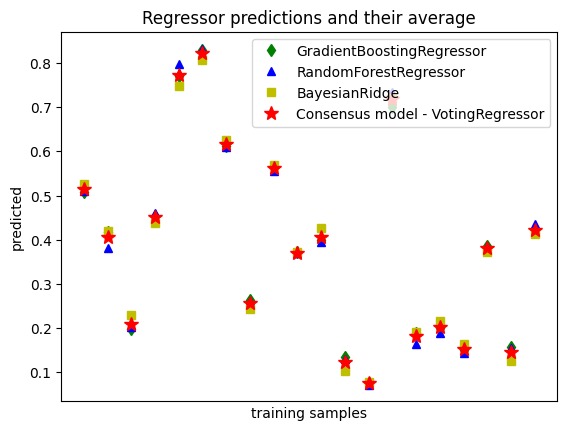

In [ ]:
import matplotlib.pyplot as plt

xt = other_x_train[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

plt.figure()
plt.plot(pred1, "gd", label="GradientBoostingRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(pred3, "ys", label="BayesianRidge")
plt.plot(pred4, "r*", ms=10, label="Consensus model - VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

### Basketball

In [ ]:
df = basketball_df

unibet_df = df[df['bookmaker'] == 'Unibet']
william_hill_df = df[df['bookmaker'] == 'William Hill']
bet365_df = df[df['bookmaker'] == 'bet365']

other_bookmakers = df[~df['bookmaker'].isin(['Unibet', 'William Hill', 'bet365'])]

In [ ]:
df_list = [unibet_df, william_hill_df, bet365_df, other_bookmakers]

for df, name in zip(df_list, ['unibet', 'william hill', 'bet365', 'others']):
  print(f"{df.shape}: {name}")

(78903, 13): unibet
(59219, 13): william hill
(77706, 13): bet365
(373739, 13): others


In [ ]:
x_var = ['decimal-home', 'decimal-away']
y = ['match-result']

unibet_x_train , unibet_x_test, unibet_y_train, unibet_y_test = train_test_split(unibet_df[x_var], unibet_df[y], random_state=0)
william_hill_x_train , william_hill_x_test, william_hill_y_train, william_hill_y_test = train_test_split(william_hill_df[x_var], william_hill_df[y], random_state=0)
bet365_x_train , bet365_x_test, bet365_y_train, bet365_y_test = train_test_split(bet365_df[x_var], bet365_df[y], random_state=0)
other_x_train , other_x_test, other_y_train, other_y_test = train_test_split(other_bookmakers[x_var], other_bookmakers[y], random_state=0)

## Save the model

In [ ]:
# save to file
from joblib import dump

dump(ereg, '/content/drive/MyDrive/regmodel.pkl')

['/content/drive/MyDrive/regmodel.pkl']

In [ ]:
ereg.predict([[0.4, 0.1,]])

array([0.63802167])